# Machine Learning for Medicine TP 5
## Logistic Regression | K-fold cross validation

In [1]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn import linear_model, datasets

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score
import os
import pandas as pd
import numpy as np

data_dir = 'data'

### Datasets

In [20]:
# First simulated data set
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,
n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=25, edgecolor='k')
plt.show()

In [21]:
# Second simulated data set
plt.title("Three blobs", fontsize='small')
X2, Y2 = make_blobs(n_samples=200, n_features=2, centers=3)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2, s=25, edgecolor='k')
plt.show()

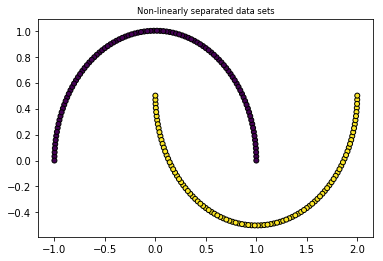

In [22]:
# Third simulated data set
plt.title("Non-linearly separated data sets", fontsize='small')
X3, Y3 = make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3, s=25, edgecolor='k')
plt.show()

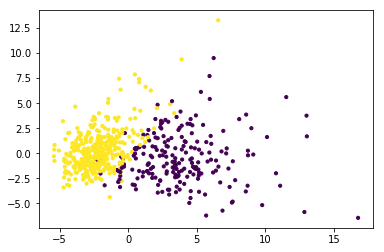

In [23]:
# Breast cancer
X = pd.read_csv('data/Breast.txt',sep=' ')
Y4 = X.values[:,30]==1 # Classes
X4 = X.values[:,0:29] # Observations

X4_pca = PCA(n_components=2).fit_transform(X4)
plt.scatter(X4_pca[:, 0], X4_pca[:, 1], s=10, c=Y4)
plt.show()

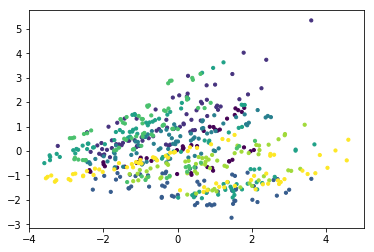

In [24]:
### Mice Protein Expression Data Set 
mice_ds = pd.read_excel(os.path.join(data_dir, "Data_Cortex_Nuclear.xls"))
mice_ds = mice_ds.set_index("MouseID")
mice_ds['class']  = mice_ds['class'] .astype('category')
# print(mice_ds['class'])

# remove all nan :
mice_ds = mice_ds[~mice_ds.isna().any(axis=1)]

Y5 = mice_ds['class'].cat.codes.astype('float').values
X5 = mice_ds[mice_ds.columns[:-4]].values

X5_pca = PCA(n_components=2).fit_transform(X5)
plt.scatter(X5_pca[:, 0], X5_pca[:, 1], s=10, c=Y5)
plt.show()


### Plot functions

In [25]:
# from Maxime sangner
from matplotlib import cm


def plotXY(X, Y, legend=True):
    """
        Scatter points from two classes.
        Input:
            X and Y may be:
            - two numpy arrays with two columns; each array is the data matrix for a class (works only for
            two classes).
            - a numpy array with two columns (the data matrix) and the vector of labels (works for many classes).
    """    
    if Y.ndim > 1:
        X1 = X
        X2 = Y
        XX = np.concatenate((X, Y), axis=0)
        YY = np.concatenate((np.ones(X.shape[0]), -np.ones(Y.shape[0])))
    else:
        XX = X
        YY = Y
    for icl, cl in enumerate(np.unique(YY)):
        plt.scatter(XX[YY==cl, 0], XX[YY==cl, 1], label='Class {0:d}'.format(icl+1))
    plt.axis('equal')
    if legend:
        plt.legend()

def plot_frontiere(clf, data=None, num=500, label=None, colors='r'):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = clf.decision_function(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
    cs = plt.contour(x, y, z, [0], colors=colors)
    if label is not None:
        cs.levels = [label]
        plt.gca().clabel(cs)
    return cs

def map_regions(clf, data=None, num=500):
    """
        Map the regions f(x)=1…K of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: classifier with a method predict
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = clf.predict(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cm.coolwarm,
              alpha=0.3)


### Experiments

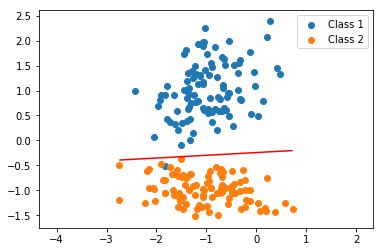

In [26]:
data, labels = X1, Y1
clf = linear_model.LogisticRegression(C=1e5, solver='newton-cg').fit(data, labels)

plotXY(data, labels)
plot_frontiere(clf, data=data)
# map_regions(clf, data=data)


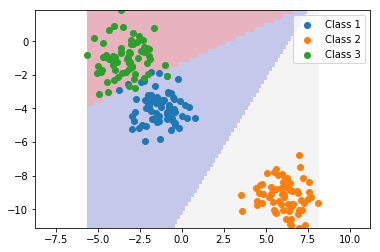

In [30]:
data, labels = X2, Y2
clf = linear_model.LogisticRegression(C=1e5, solver='newton-cg', multi_class='auto').fit(data, labels)

plotXY(data, labels)
# plot_frontiere(clf, data=data)
map_regions(clf, data=data)


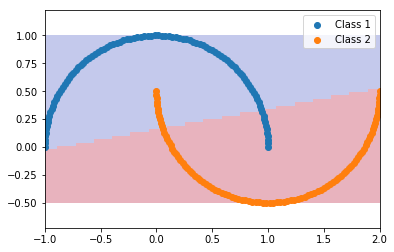

In [31]:
data, labels = X3, Y3
clf = linear_model.LogisticRegression(C=1e5, solver='newton-cg').fit(data, labels)

plotXY(data, labels)
# plot_frontiere(clf, data=data)
map_regions(clf, data=data)


### K-folds

In [32]:
from sklearn.model_selection import KFold

## computes the k-folds precision score :

def score_kfolds(data, labels, clf, folds=20):
    rs = KFold(n_splits=folds)
    scores = []
    for train_idx, test_idx in rs.split(data):
        x_train, y_train = data[train_idx], labels[train_idx]
        x_test,  y_test  = data[ test_idx], labels[ test_idx]
        sc_forest = clf.fit(x_train, y_train).score(x_test, y_test)
        scores.append(sc_forest)
    return np.mean(scores)


### Binary Logistic regression

In [33]:
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin, ClassifierMixin

class MyBinaryLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, num_iter=10):
        self.num_iter = num_iter
        
    def fit(self, X, y):
        self.theta = np.zeros(X.shape[1])
        self.scores_ = []
        for i in range(self.num_iter):
            p_y1 = self.decision_function(X)
            d1L = - np.sum( X * (y-p_y1).reshape(-1,1) , axis=0)
            d2L = np.sum(np.stack([np.outer(xx,xx) for xx in X], axis=0) * (p_y1*(1-p_y1)).reshape(-1,1,1), axis=0)
            self.theta = self.theta - np.linalg.inv(d2L) @ d1L
            self.scores_.append(self.score(X,y))
        return self
    
    def decision_function(self, X):
        exp_tx = np.exp(np.dot(X, self.theta))
        p_y1 = exp_tx/(1+exp_tx)
        return p_y1

    def predict(self, X):
        p_y1 = self.decision_function(X)
        labels = [p>.5 for p in p_y1]
        return np.array(labels)
    

MyBinaryLogisticRegression score 10 folds :  0.9899999999999999
sklearn.linear_model.LogisticRegression score 10 folds :  0.9799999999999999


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


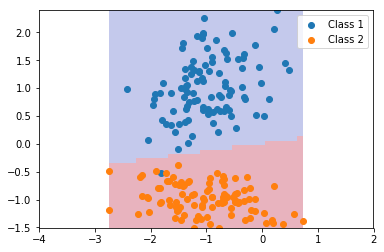

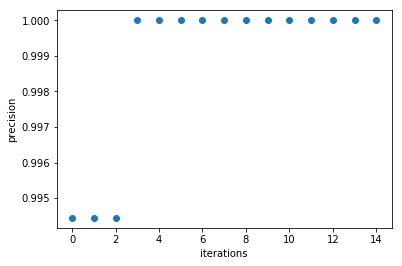

In [34]:
data, labels = X1, Y1

num_iter = 15
clf = MyBinaryLogisticRegression(num_iter=num_iter)
s = score_kfolds(data, labels, clf, folds=10)
print('MyBinaryLogisticRegression score 10 folds : ', s)
clf2 = linear_model.LogisticRegression(C=1e5, max_iter=num_iter, solver='newton-cg')
s = score_kfolds(data, labels, clf2, folds=10)
print('sklearn.linear_model.LogisticRegression score 10 folds : ', s)

plotXY(data, labels)
map_regions(clf, data=data)
plt.show()

plt.plot(clf.scores_, 'o')
plt.xlabel('iterations')
plt.ylabel('precision')
plt.show()

MyBinaryLogisticRegression score 10 folds :  0.875
sklearn.linear_model.LogisticRegression score 10 folds :  0.885


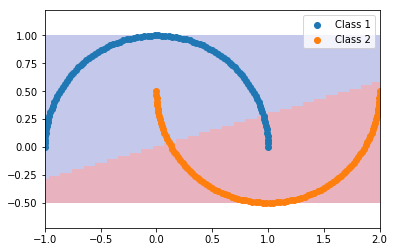

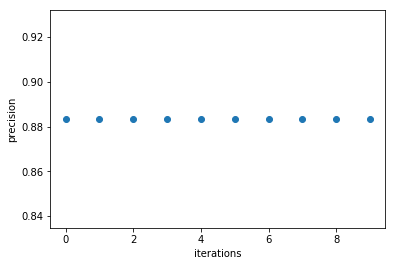

In [35]:
data, labels = X3, Y3

num_iter = 10
clf = MyBinaryLogisticRegression(num_iter=num_iter)
s = score_kfolds(data, labels, clf, folds=10)
print('MyBinaryLogisticRegression score 10 folds : ', s)
clf2 = linear_model.LogisticRegression(C=1e5, max_iter=num_iter, solver='newton-cg')
s = score_kfolds(data, labels, clf2, folds=10)
print('sklearn.linear_model.LogisticRegression score 10 folds : ', s)

plotXY(data, labels)
map_regions(clf, data=data)
plt.show()

plt.plot(clf.scores_, 'o')
plt.xlabel('iterations')
plt.ylabel('precision')
plt.show()


Breast Cancer dataset:
MyBinaryLogisticRegression score 10 folds :  0.9525062656641602
sklearn.linear_model.LogisticRegression score 10 folds :  0.9666040100250625


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-

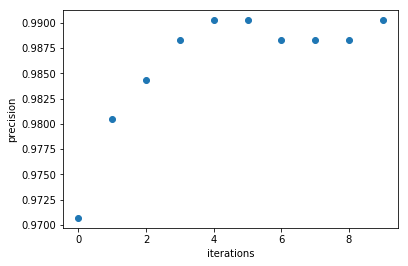

In [36]:
data, labels = X4, Y4

print('Breast Cancer dataset:')

num_iter = 10
clf = MyBinaryLogisticRegression(num_iter=num_iter)
s = score_kfolds(data, labels, clf, folds=10)
print('MyBinaryLogisticRegression score 10 folds : ', s)
clf2 = linear_model.LogisticRegression(C=1e5, max_iter=num_iter, solver='newton-cg')
s = score_kfolds(data, labels, clf2, folds=10)
print('sklearn.linear_model.LogisticRegression score 10 folds : ', s)

plt.plot(clf.scores_, 'o')
plt.xlabel('iterations')
plt.ylabel('precision')
plt.show()


In [37]:
data, labels = X5, Y5
print('Mice dataset:')

num_iter = 100
# clf = MyBinaryLogisticRegression(num_iter=num_iter)
# s = score_kfolds(data, labels, clf, folds=10)
# print('MyBinaryLogisticRegression score 10 folds : ', s)
clf2 = linear_model.LogisticRegression(C=1e5, max_iter=num_iter, solver='newton-cg', multi_class='auto')
s = score_kfolds(data, labels, clf2, folds=10)
print('sklearn.linear_model.LogisticRegression score 10 folds : ', s)

# plt.plot(clf.scores_, 'o')
# plt.xlabel('iterations')
# plt.ylabel('precision')
# plt.show()


Mice dataset:
sklearn.linear_model.LogisticRegression score 10 folds :  0.4517207792207792


>> Comme le classifieur implémenté (`MyBinaryLogisticRegression`) est binaire, on ne peut pas le tester sur Mice et le dataset artificiel numero 2. Mais sur les autres datasets on observe des scores légèrement inférieurs mais proches du classifieur `sklearn`.
De plus il semblerait que `MyBinaryLogisticRegression` converge plus rapidement que `sklearn.linear_model.LogisticRegression`.